# Regression 실습 - 자전거 대여 수요 예측

자전거를 몇 일에 몇대를 빌려갈 것인가

## 데이터 클렌징 및 가공

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

from matplotlib import font_manager, rc 
plt.rcParams['axes.unicode_minus'] = False
font_name = font_manager.FontProperties(fname= "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
bike_df = pd.read_csv('../data/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


#### 2011년 1월 ~ 2012년 12월
* 날짜,/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있음<br>
* datetime: hourly date + timestamp  
* season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
* holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
* workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
* weather:  
    1 = 맑음, 약간 구름 낀 흐림  
    2 = 안개, 안개 + 흐림  
    3 = 가벼운 눈, 가벼운 비 + 천둥  
    4 = 심한 눈/비, 천둥/번개  
* temp: 온도(섭씨)   
* atemp: 체감온도(섭씨)  
* humidity: 상대습도  
* windspeed: 풍속  
* casual: 사전에 등록되지 않는 사용자가 대여한 횟수  
* registered: 사전에 등록된 사용자가 대여한 횟수  
* count: 대여 횟수

In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
# 문자열을 datetime 타입으로 변경(오브젝트 타입을 날짜 타입으로 바꿔)
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [8]:
# datetime타입에서 년, 월, 일, 시간 추출해서 각 칼럼 만들어 넣음.
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
print(bike_df.info())
bike_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [9]:
# 필요없는 칼럼 자르기.
#'casual', 'registered' 두개 합하면 count에 있으므로 삭제
drop_colums = ['datetime', 'casual', 'registered']
bike_df.drop(drop_colums, axis=1, inplace=True)

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가
* https://www.kaggle.com/c/bike-sharing-demand/overview/evaluation
* RMSLE(실제값과 예측값의 오류를 로그로 변환한 뒤 RMSE를 적용)<br>
과대평가된 항목보다 과소평가 된 항목에 패널티를 준다. <br>
값이 작을 수록 회귀성능이 좋은 것이다. 예측한 값과 실제값이 차이가 없다는 말이다.<br>
0에 가까울 수 록 정밀도가 높다.-평가지표(실제값 예측값 차이)

* MAE(Mean Absolue Error) : 실제값과 예측값의 차이를 절대값으로 반환해 평균한것
* MSE(Mean Squared Error) : 실제값과 예측값의 차이를 제곱해 평균한 것
* RMSE(Foot Mean Squared Error) : MSE값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 RMSE 값을 쓴다.
* MSLE(Mean Squared Log Error) : MSE에 로그를 적용해 준 지표입니다. log(y)가 아니라 log(y+1)입니다. y=0일때 log(y)는 마이너스 무한대이므로 이를 보정해주기 위해 +1을 한 것이다.
* RMSLE(Root Mean Squred LogError) : RMSE에 로그를 적용해준 지표이다.
* R제곱(R Sqare) : R 제곱은 분산기반으로 예측 성능을 평가 1에 가까울수록 예측정확도가 높다.   

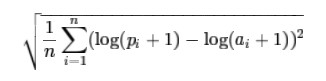

In [11]:
from IPython.display import Image
Image("../data/rmsle수식.jpg")

* 수식 참조 사이트 : https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-17-%ED%9A%8C%EA%B7%80-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C?category=1057680

In [19]:
# 평가도구
from sklearn.metrics import mean_squared_error, mean_absolute_error
#log 값 변환시 NaN등의 이슈로 log()가 아닌 log1p()를 이용하여 RMSLE계산
#log 값이 무한대로 적용되기에 그걸 막기 위해 함수값인 log1p사용
#사이킷런에 RMSLE 가 없어서 함수 만들것임
#실제값과 예측값에 RMSLE 적용
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) **2 #실제값-예측값의 제곱
    rmsle = np.sqrt(np.mean(squared_error)) #sqrt는 루트씌운것
    return rmsle

#사이킷런의 mean_squre_error()를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

#MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    #MSE는 scikit learn의 mean_absoulte_error()로 계산
    mse_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MSE : {2:.3F}'.format(rmsle_val, rmse_val, mse_val))

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count'] #자전거 몇대 빌릴지가 타겟값
X_features = bike_df.drop(['count'], axis=1, inplace=False) 
#count 제외한(타겟값 제외하고)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MSE : 105.924


In [23]:
def get_top_error_data(y_test, pred, n_tops = 5):
    #DataFrame에 컬럼들로 실제 대여횟수(count)와 예측값을 서로 비교할수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    #abs절대값 (실제값-절대값)
    #예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

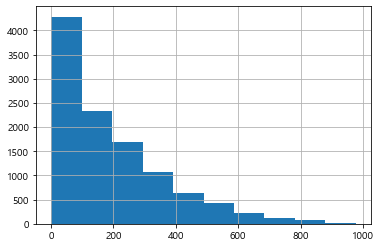

In [25]:
#차이많이 나니 데이터 분포값으로 확인하기
y_target.hist()

* 0~200 사이에 데이터가 왜곡되어 있음.<br>
한쪽으로 치우쳤기 때문에 정규분포로 만들어 놓고 해야해

<AxesSubplot:>

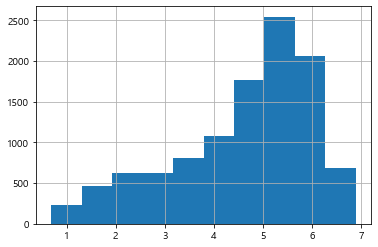

In [27]:
# 왜곡된 값을 정규분포 형태로 바꿈 log1p -> 원상복귀는 expm1 - 완전한 정규분포는 아니지만 왜곡이 좀 향상됨
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [30]:
#타겟 칼럼인 count 값을 log1p로 Log 변환
y_target_log = np.log1p(y_target) #log1p = log+1

#로그변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, 
                                                test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#테스트 데이터 셋의 Target값은 Log 변환
#-> 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

#예측값 역시 Log 변환된 타겟 기반으로 학습되어 예측되엇으므로 다시 exmpl으로 scale 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)
#이전=> RMSLE: 1.165, RMSE: 140.900, MSE : 105.924

RMSLE: 1.017, RMSE: 162.594, MSE : 109.286


* 이전에 비해 RMSLE 오류는 줄었지만, RMSE와 MSE는 더 늘었다.
* 값이 적을수록 더 정확한것인데..

<AxesSubplot:>

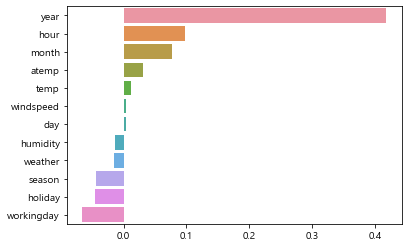

In [31]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

* 각 피처의 회귀 계수 값을 시각화 - year(2011,20212값) 피처의 회귀계수 값이 독보적으로 크다.
* 자전거 타는데 대여횟수에 year가 그렇게 중요한 값은 아니다.
* 날씨, 계절,...이런건 대여횟수에 영향을 주지만..
* year피처는 연도를뜻하므로 카테고리형 피처지만 숫자값으로 돼 잇어 이것을 One Hot Encodin적용(선형회귀할때 바꿔야해)
* 숫자형 카테고리 값을 선형회귀에 사용할 경우 회귀 게수를 연산할때 이 숫자형 값에 크게영향을 받는 경우가 발생하므로 주의

In [38]:
# year, month, hour, season,weather, feaure들을 원 핫 인코딩 적용(범주형으로)
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','hour','holiday', 'workingday', 'season', 'weather'])

In [44]:
# 원핫 인코딩이 적용된 feature데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, 
                                                test_size=0.3, random_state=0)
#모델과 학습/테스트 데이터 셋을 입려하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):#로그값 변환false
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test,pred)#아까 만들어 놓은 함수 :MSE, RMSE, RMSLE 를 모두 계산
   
# model별로 평가수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10) #alpha 규제
lasso_reg = Lasso(alpha=0.01) #alpha 규제

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test, is_expm1=True)    
    

### LinearRegression ###
RMSLE: 0.589, RMSE: 97.483, MSE : 63.106
### Ridge ###
RMSLE: 0.589, RMSE: 98.407, MSE : 63.648
### Lasso ###
RMSLE: 0.634, RMSE: 113.031, MSE : 72.658


* 성능이 엄청 좋아짐
* 이전 : 1.017, RMSE: 162.594, MSE : 109.286 (실제값 예측값 모두 줄어들었다.)
* 선형 회귀 수행시 - 피처를 어떻게 인코딩 하는가가 성능에 중요한 영향을 미칠 수 있다.(숫자 진짜 숫자 아니고 범주형 데이터)

<AxesSubplot:>

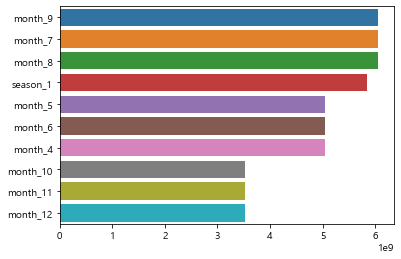

In [45]:
#month_9, month_7, month_8, season_1등의 피처 회귀 계수가 높게 나왔다.
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

### 모델 몇개만 더 집어넣어보자

* 이전에 만들어 놓은 함수로 계산할수 있다. (get_model_predict)

#### 회귀 트리 - 평가지표 예측

In [50]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#랜덤 포레스트, GBM, xgboost,lightgbm별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500) #전문가 여러명의 의견 평균
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)
    
# xgboost와 lightgbm 안올라오면 아나콘다프롬프트에서 pip install 하고 두개 올리면 됨

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.754, MSE : 31.516
### GradientBoostingRegressor ###
RMSLE: 0.340, RMSE: 55.770, MSE : 34.337
### XGBRegressor ###
RMSLE: 0.339, RMSE: 50.950, MSE : 30.891
### LGBMRegressor ###
RMSLE: 0.316, RMSE: 46.473, MSE : 28.777


* 이전에 선형 회귀 모형<br>
LinearRegression<br>
RMSLE: 0.589, RMSE: 97.483, MSE : 63.106<br>
Ridge <br>
RMSLE: 0.589, RMSE: 98.407, MSE : 63.648<br>
Lasso <br>
RMSLE: 0.634, RMSE: 113.031, MSE : 72.658
            * 선형 회귀 모델보다 회귀 예측 성능이 개선됨.

* 회귀 트리를 이용해 회귀 예측을 수행
* 선형 회귀 모델보다 회귀 예측 성능이 개선됨. (아래 선형회귀 모델 있음.)
* 데이터 세트의 유형에 따라 결과는 달라질 수 있음.(하지만 항상 그런것은 아니다.)